In [5]:
import numpy
import pickle

from matplotlib import pyplot

PIXELSIZE = 15e-3
FEATURES = ["Area", "Perimeter", "Mean Intensity", "Eccentricity", "Solidity", "Density", "NN"]
COLORS = {
    "Block" : "gray",
    "0MgGlyBic" : "darkseagreen",
    "GluGly" : "peru",
}

def flatten(values):
    out = []
    for v in values:
        out.extend(v)
    return numpy.array(out)

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())


dict_keys(['0MgGlyBic', 'Block', 'GluGly'])


0MgGlyBic
511
Block
512
GluGly
510


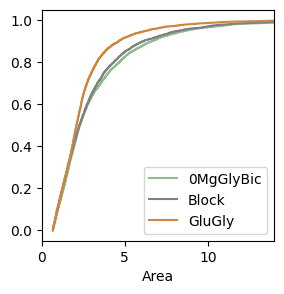

0MgGlyBic
511
Block
512
GluGly
510


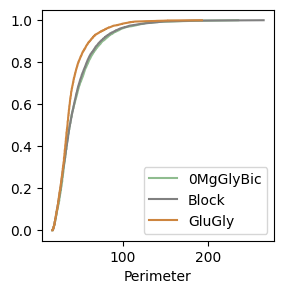

0MgGlyBic
511
Block
512
GluGly
510


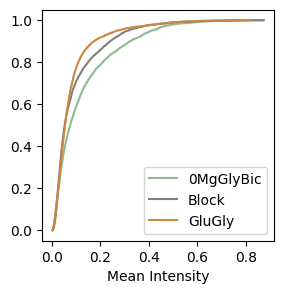

0MgGlyBic
511
Block
512
GluGly
510


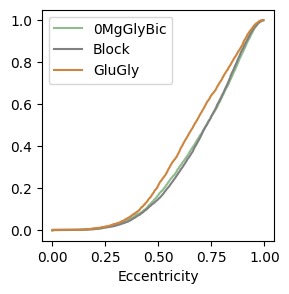

0MgGlyBic
511
Block
512
GluGly
510


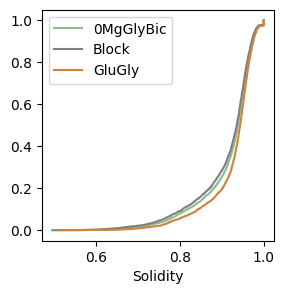

0MgGlyBic
511
Block
512
GluGly
510


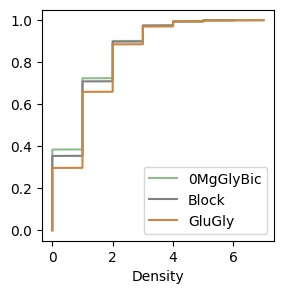

0MgGlyBic
511
Block
512
GluGly
510


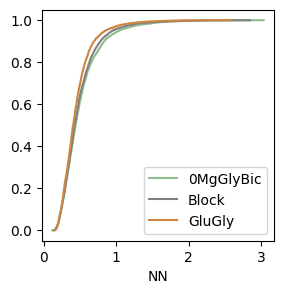

In [25]:
def flatten(values):
    out = []
    for v in values:
        if v is None:
            continue
        out.extend(v)
    return numpy.array(out)

for i, feature_name in enumerate(FEATURES):
    fig, ax = pyplot.subplots(figsize=(3, 3))
    for key, values in data.items():
        print(key)
        print(len(values))

        features = flatten(values)
        feats = numpy.sort(features[:, i])
        if feature_name == "Area":
            feats = feats * (PIXELSIZE ** 2) * 1e+2
            ax.set_xlim(0, 14)

        ax.plot(feats, numpy.linspace(0, 1, len(feats)), label=key, color=COLORS[key])
    ax.legend()
    ax.set_xlabel(feature_name)
    pyplot.show()
        

# From original data

In [8]:
import tifffile
import os
import numpy
import glob

from skimage import feature, measure, morphology
from scipy.spatial import distance
from tqdm.auto import tqdm

from wavelet import detect_spots

conditions = ["Block", "0MgGlyBic", "GluGly"]
PIXELSIZE = 15e-3
CHANNEL = 1 # 0: Bassoon; 1: PSD95
PATH = "/home-local2/projects/SSL/evaluation-data/TheresaProteins"

dataset = {}
for condition in conditions:
    filenames = glob.glob(os.path.join(PATH, condition, "*.tif"))
    dataset[condition] = filenames
    print(condition, len(filenames))

Block 18
0MgGlyBic 20
GluGly 7


In [10]:
def extract_features(image, show=False):
    
    image = tifffile.imread(image)[CHANNEL]

    PIXELSIZE = 0.015 # in um
    # mask = detect_spots(image, J_list=[2, 3], scale_threshold=5.0)
    mask = detect_spots(image, J_list=[3, 4], scale_threshold=2.0)

    if show:    
        fig, axes = pyplot.subplots(1, 2)
        axes[0].imshow(image, cmap='gray')
        axes[1].imshow(mask, cmap='gray')
        pyplot.show()

    mask_label, num_proteins = measure.label(mask, return_num=True)
    props = measure.regionprops(mask_label, intensity_image=image)
    coordinates = numpy.array([p.weighted_centroid for p in props])

    distances = distance.pdist(coordinates) * PIXELSIZE
    distances = distance.squareform(distances)

    nn_distances = numpy.sort(distances, axis=1)[:, 1]

    image_density = num_proteins / (image.shape[0] * image.shape[1] * PIXELSIZE**2)
    density_proteins = (numpy.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2

    features = []
    counter = 0
    for prop, density, nn in zip(props, density_proteins, nn_distances):

        img = prop.intensity_image
        label = prop.image

        min_distance = int(0.08 / PIXELSIZE) // 2 + 1 # in pixels
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False)

        if show:
            fig, axes = pyplot.subplots(1, 2)
            axes[0].imshow(img, cmap='gray')
            axes[0].plot(peaks[:, 1], peaks[:, 0], 'r.')
            axes[1].imshow(label, cmap='gray')
            pyplot.show()

        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.solidity,
            density,
            nn,
            # len(peaks)
        ])

        # counter += 1
        # if counter > 5:
        #     break

    return numpy.array(features)    

from collections import defaultdict
aggregated = defaultdict(list)
for condition, filenames in dataset.items():
    print(condition)
    for filename in tqdm(filenames):
        features = extract_features(filename)
        aggregated[condition].append(features)

Block


  0%|          | 0/18 [00:00<?, ?it/s]

0MgGlyBic


  0%|          | 0/20 [00:00<?, ?it/s]

GluGly


  0%|          | 0/7 [00:00<?, ?it/s]

Block
18
0MgGlyBic
20
GluGly
7


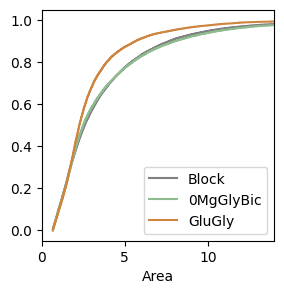

Block
18
0MgGlyBic
20
GluGly
7


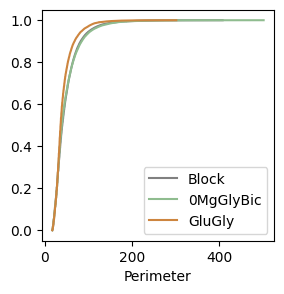

Block
18
0MgGlyBic
20
GluGly
7


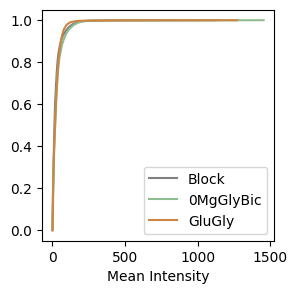

Block
18
0MgGlyBic
20
GluGly
7


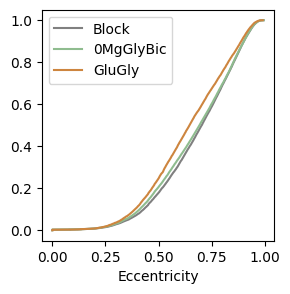

Block
18
0MgGlyBic
20
GluGly
7


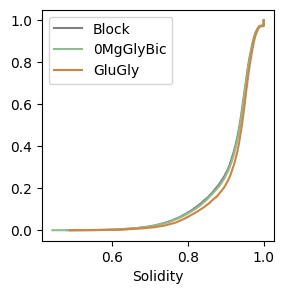

Block
18
0MgGlyBic
20
GluGly
7


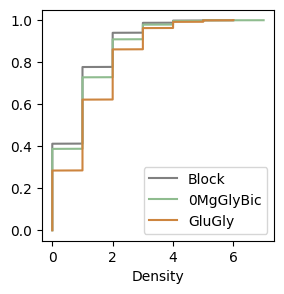

Block
18
0MgGlyBic
20
GluGly
7


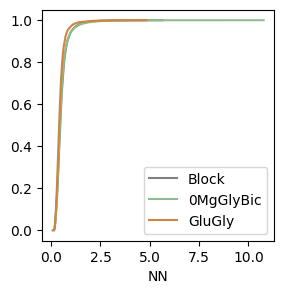

In [11]:
for i, feature_name in enumerate(FEATURES):
    fig, ax = pyplot.subplots(figsize=(3, 3))
    for key, values in aggregated.items():
        print(key)
        print(len(values))

        features = flatten(values)
        feats = numpy.sort(features[:, i])
        if feature_name == "Area":
            feats = feats * (PIXELSIZE ** 2) * 1e+2
            ax.set_xlim(0, 14)

        ax.plot(feats, numpy.linspace(0, 1, len(feats)), label=key, color=COLORS[key])
    ax.legend()
    ax.set_xlabel(feature_name)
    pyplot.show()


# From pySODA

In [6]:
import numpy
import os
import glob
import pandas

from collections import defaultdict
from matplotlib import pyplot

conditions = ["Block", "0MgGlyBic", "GluGly"]
PIXELSIZE = 15e-3
CHANNEL = 0
PATH = "/home-local2/projects/SSL/evaluation-data/TheresaProteins"

dataset = {}
for condition in conditions:
    filenames = glob.glob(os.path.join(PATH, condition, "SODA", "*.xlsx"))
    filenames = list(filter(lambda x: "results" not in x, filenames))
    dataset[condition] = filenames
    print(condition, len(filenames))

Block 18
0MgGlyBic 20
GluGly 7


In [15]:
# PSD-Bassoon
aggregated = defaultdict(list)
aggregated_coupled = defaultdict(list)
aggregated_all = defaultdict(list)
for condition, filenames in dataset.items():
    print(condition)
    for filename in filenames:
        xl = pandas.ExcelFile(filename)
        sheet = xl.sheet_names
        df = pandas.read_excel(filename, sheet_name=sheet[2])

        areas = df["Area"].values
        coupled = df["Coupled"].values.astype(bool)
        uncoupled = numpy.invert(coupled)

        # print(df.head())
        aggregated_coupled[condition].append(areas[coupled])
        aggregated[condition].append(areas[uncoupled])
        aggregated_all[condition].append(areas)
        

Block
0MgGlyBic
GluGly


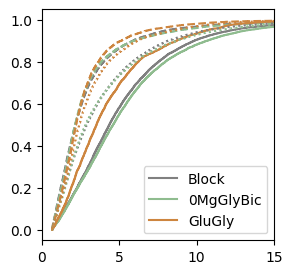

In [16]:
fig, ax = pyplot.subplots(figsize=(3, 3))
for key, values in aggregated.items():
    values = flatten(values)

    feats = numpy.sort(values)
    feats = feats * (PIXELSIZE ** 2) * 1e+2
    ax.set_xlim(0, 15)
    ax.plot(feats, numpy.linspace(0, 1, len(feats)), color=COLORS[key], linestyle="dashed")

for key, values in aggregated_coupled.items():
    values = flatten(values)

    feats = numpy.sort(values)
    feats = feats * (PIXELSIZE ** 2) * 1e+2
    ax.set_xlim(0, 15)
    ax.plot(feats, numpy.linspace(0, 1, len(feats)), label=key, color=COLORS[key])

for key, values in aggregated_all.items():
    values = flatten(values)

    feats = numpy.sort(values)
    feats = feats * (PIXELSIZE ** 2) * 1e+2
    ax.set_xlim(0, 15)
    ax.plot(feats, numpy.linspace(0, 1, len(feats)), color=COLORS[key], linestyle="dotted")
ax.legend()
pyplot.show()